In [1]:
#classes = hp['classes']

import pandas as pd
#import xlrd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.impute import KNNImputer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
pd.DataFrame.iteritems=pd.DataFrame.items
tf.compat.v1.disable_v2_behavior()
# change the strings to ints
#input= pd.DataFrame(pd.read_csv("US Insurance Claims Data.xlsx", encoding='utf-16-le', encoding_errors='ignore'))


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_excel("US_Insurance_Claims_Data.xlsx")

# Step 1: Separate datetime columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
df_datetime = df[datetime_cols]

# Step 2: Exclude datetime columns for KNN imputation
df_knn = df.drop(columns=datetime_cols).copy()

# Step 3: Label encode categorical columns
label_encoders = {}
for col in df_knn.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    label_encoders[col] = le

# Step 4: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

# Step 5: Round integer columns
for col in df_knn.select_dtypes(include='int64').columns:
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)

# Step 6: Reverse label encoding
for col, le in label_encoders.items():
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)
    df_knn_imputed[col] = le.inverse_transform(df_knn_imputed[col])

# Step 7: Reattach datetime columns
df_cleaned = pd.concat([df_knn_imputed, df_datetime.reset_index(drop=True)], axis=1)

# Step 8: Final check
print("Missing values after KNN imputation:", df_cleaned.isnull().sum().sum())

# Optional: Save result
df_cleaned.to_csv("US_Insurance_KNN_Imputed.csv", index=False)
input=pd.read_csv("US_Insurance_KNN_Imputed.csv")
input=input.fillna(method='bfill').fillna(method='ffill')

Missing values after KNN imputation: 0


/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_41178/3358762314.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  input=input.fillna(method='bfill').fillna(method='ffill')


In [3]:
input.incident_location=input.incident_location.astype('category').cat.codes
input.policy_state=input.policy_state.astype('category').cat.codes
input.insured_education_level=input.insured_education_level.astype('category').cat.codes
input.insured_sex=input.insured_sex.astype('category').cat.codes
input.insured_hobbies=input.insured_hobbies.astype('category').cat.codes
input.insured_relationship=input.insured_relationship.astype('category').cat.codes
input.incident_type=input.incident_type.astype('category').cat.codes
input.collision_type=input.collision_type.astype('category').cat.codes
input.incident_severity=input.incident_severity.astype('category').cat.codes
input.authorities_contacted=input.authorities_contacted.astype('category').cat.codes
input.incident_state=input.incident_state.astype('category').cat.codes
input.incident_city=input.incident_city.astype('category').cat.codes
input.insured_occupation=input.insured_occupation.astype('category').cat.codes
input.property_damage=input.property_damage.astype('category').cat.codes
input.police_report_available=input.police_report_available.astype('category').cat.codes
input.auto_make=input.auto_make.astype('category').cat.codes
input.auto_model=input.auto_model.astype('category').cat.codes
#input['fraud_reported']=input['fraud_reported'].fillna(method='ffill').fillna(method='bfill')
input.fraud_reported=input.fraud_reported.astype('category').cat.codes
input.incident_date=input.incident_date.astype('category').cat.codes
input.policy_bind_date=input.incident_date.astype('category').cat.codes
input['policy_csl'] = input['policy_csl'].apply(lambda x: eval(x))

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.preprocessing.sequence import pad_sequences

#trainX_padded = pad_sequences(trainX, padding='post', truncating='post')
#testX_padded = pad_sequences(testX, padding='post', truncating='post')
#trainY_padded = pad_sequences(trainY, padding='post', truncating='post')
#testY_padded = pad_sequences(testY, padding='post', truncating='post')



grouped = input.groupby('months_as_customer')

# Extract sequences and labels
sequences = grouped.apply(lambda X: X[['months_as_customer', 'age', 'policy_number', 'policy_bind_date' , 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year']].values.tolist())
labels = grouped['fraud_reported'].first().values
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad to same length (post-padding with zeros)
X = pad_sequences(sequences.tolist(), padding='post', dtype='float32')
y = np.array(labels)
# Flatten time dimension to create 2D array for VIF calculation
# Shape: (samples * timesteps, features)
X_2d_for_vif = X.reshape(-1, X.shape[2])

def calculate_vif_3d(X_2d, thresh=5.0):
    print("Calculating VIF for each feature (collapsed over timesteps)...")
    variables = list(range(X_2d.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_2d[:, variables], ix) for ix in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Dropping feature at index {variables[maxloc]} with VIF={max_vif:.2f}")
            variables.pop(maxloc)
            dropped = True
    return variables

# Calculate VIF and get list of features to keep
features_to_keep = calculate_vif_3d(X_2d_for_vif, thresh=10.0)

print(f"Selected {len(features_to_keep)} features out of {X.shape[2]} based on VIF")

# Filter original X on feature dimension (3rd dimension)
X_filtered = X[:, :, features_to_keep]

# Now flatten for SMOTE and undersampling (samples, timesteps*features_kept)
X_flat = X_filtered.reshape(X_filtered.shape[0], -1)

smote = SMOTE(sampling_strategy=0.8, random_state=42)
#rus = RandomUnderSampler(random_state=1000)

# Apply SMOTE then undersampling
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
#X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

timesteps = X_filtered.shape[1]
features_kept = X_filtered.shape[2]

X_resampled = X_resampled.reshape(-1, timesteps, features_kept)

#print(f"Original shape: {X.shape}")
#print(f"Filtered shape (after VIF): {X_filtered.shape}")
#print(f"Resampled shape: {X_resampled_3d.shape}")
#print(f"Original class distribution: {np.bincount(y)}")
#print(f"Resampled class distribution: {np.bincount(y_resampled)}")

# X_resampled_3d, y_resampled are now ready for your sequential model


Calculating VIF for each feature (collapsed over timesteps)...
Dropping feature at index 3 with VIF=1576338686514.00
Dropping feature at index 31 with VIF=6543.02
Dropping feature at index 37 with VIF=226.42
Dropping feature at index 1 with VIF=107.59
Dropping feature at index 9 with VIF=38.70
Dropping feature at index 5 with VIF=27.07
Dropping feature at index 7 with VIF=22.99
Dropping feature at index 34 with VIF=18.26
Dropping feature at index 26 with VIF=13.62
Selected 29 features out of 38 based on VIF



📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 12:15:46.568630: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-12-03 12:15:46.596302: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/bias/v/Assign' id:1311 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/bias/v, training/Adam/dense_2/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updat

🔍 Calculating SHAP values for fold 1 of 'Convex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 12:23:31.252183: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_5/kernel/v/Assign' id:3243 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_5/kernel/v, training_2/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 12:23:36.261227: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_2/mul' id:257


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 12:31:34.278466: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_10/bias/v/Assign' id:4729 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_10/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_10/bias/v, training_4/Adam/dense_10/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 12:31:39.431520: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_3/mul' id:4056 op


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 12:39:49.700237: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/dense_17/bias/v/Assign' id:6234 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_17/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_17/bias/v, training_6/Adam/dense_17/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 12:39:54.878165: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_4/mul' id:5537 op


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 12:48:00.406688: W tensorflow/c/c_api.cc:305] Operation '{name:'training_8/Adam/dense_21/kernel/m/Assign' id:7621 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_21/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_21/kernel/m, training_8/Adam/dense_21/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 12:48:05.614609: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_5/mul' id


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 12:56:06.384765: W tensorflow/c/c_api.cc:305] Operation '{name:'lstm_5/lstm_cell/kernel/Assign' id:7906 op device:{requested: '', assigned: ''} def:{{{node lstm_5/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_5/lstm_cell/kernel, lstm_5/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 12:56:11.733587: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_6/mul' id:8499 op device:{requested: '',


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 13:04:18.600331: W tensorflow/c/c_api.cc:305] Operation '{name:'training_12/Adam/beta_1/Assign' id:10535 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/beta_1, training_12/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 13:04:23.921145: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_7/mul' id:9980 op device:{requested: '',


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 13:12:17.927845: W tensorflow/c/c_api.cc:305] Operation '{name:'training_14/Adam/dense_37/kernel/v/Assign' id:12153 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/dense_37/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/dense_37/kernel/v, training_14/Adam/dense_37/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 13:12:23.190573: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_8/mu


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 13:20:18.138402: W tensorflow/c/c_api.cc:305] Operation '{name:'training_16/Adam/dense_42/bias/v/Assign' id:13639 op device:{requested: '', assigned: ''} def:{{{node training_16/Adam/dense_42/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_16/Adam/dense_42/bias/v, training_16/Adam/dense_42/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 13:20:23.575124: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_9/mul' id:12


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-03 14:04:03.483117: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_18/Assign' id:14137 op device:{requested: '', assigned: ''} def:{{{node false_negatives_18/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_18, false_negatives_18/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 14:04:10.301326: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_10/mul' id:14423 op device:{requested: '', assigned: ''} def:{{{node


📊 Average metrics for schedule 'Convex Only': {'loss': 0.06852758394463895, 'accuracy': 0.58286387, 'precision': 0.714127, 'recall': 0.09479, 'f1': 0.1608198139464469, 'auc': 0.5625825577663949}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 14:13:59.007420: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_53/kernel/Assign' id:15567 op device:{requested: '', assigned: ''} def:{{{node dense_53/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_53/kernel, dense_53/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 14:14:05.672594: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_11/mul' id:15904 op device:{requested: '', assigned: ''} def:{{{node lo


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 14:14:58.170251: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_22/Assign' id:16782 op device:{requested: '', assigned: ''} def:{{{node false_positives_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_22, false_positives_22/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:15:04.970916: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_12/mul' id:17083 op device:{requested: '', assigned: ''} def:{{{node loss_12/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_12/mul/x, loss_12/dense_54_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 14:18:50.733588: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_38/Assign' id:17799 op device:{requested: '', assigned: ''} def:{{{node true_positives_38/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_38, true_positives_38/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:18:57.261105: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_13/mul' id:18085 op device:{requested: '', assigned: ''} def:{{{node loss_13/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul/x, loss_13/dense_54_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running

🔍 Calculating SHAP values for fold 1 of 'Multistage_1'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 14:23:29.512369: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_41/Assign' id:19593 op device:{requested: '', assigned: ''} def:{{{node true_positives_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_41, true_positives_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 14:23:36.494413: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_15/mul' id:19874 op device:{requested: '', assigned: ''} def:{{{node los


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 14:24:29.547902: W tensorflow/c/c_api.cc:305] Operation '{name:'count_14/Assign' id:20793 op device:{requested: '', assigned: ''} def:{{{node count_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_14, count_14/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:24:36.849855: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_16/mul' id:21053 op device:{requested: '', assigned: ''} def:{{{node loss_16/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_16/mul/x, loss_16/dense_59_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 14:28:34.902425: W tensorflow/c/c_api.cc:305] Operation '{name:'count_15/Assign' id:21795 op device:{requested: '', assigned: ''} def:{{{node count_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_15, count_15/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:28:41.737953: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_17/mul' id:22055 op device:{requested: '', assigned: ''} def:{{{node loss_17/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_17/mul/x, loss_17/dense_59_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📂 Fold 3/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 14:33:14.200626: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_60/bias/Assign' id:22964 op device:{requested: '', assigned: ''} def:{{{node dense_60/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_60/bias, dense_60/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 14:33:21.673378: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_18/mul' id:23359 op device:{requested: '', assigned: ''} def:{{{node loss_18/mul}} = Mul


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 14:34:17.618667: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_17/Assign' id:24257 op device:{requested: '', assigned: ''} def:{{{node true_negatives_17/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_17, true_negatives_17/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:34:24.881677: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_19/mul' id:24538 op device:{requested: '', assigned: ''} def:{{{node loss_19/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_19/mul/x, loss_19/dense_64_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 14:38:15.390464: W tensorflow/c/c_api.cc:305] Operation '{name:'total_18/Assign' id:25275 op device:{requested: '', assigned: ''} def:{{{node total_18/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_18, total_18/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:38:22.628218: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_20/mul' id:25540 op device:{requested: '', assigned: ''} def:{{{node loss_20/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_20/mul/x, loss_20/dense_64_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📂 Fold 4/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 14:43:04.102730: W tensorflow/c/c_api.cc:305] Operation '{name:'training_38/Adam/lstm_13/lstm_cell/recurrent_kernel/m/Assign' id:27423 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/lstm_13/lstm_cell/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_38/Adam/lstm_13/lstm_cell/recurrent_kernel/m, training_38/Adam/lstm_13/lstm_cell/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 14:44:08.048616: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_41/Assign' id:27752 op device:{requested: '', assigned: ''} def:{{{node false_negatives_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_41, false_negatives_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:44:15.857850: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_22/mul' id:28023 op device:{requested: '', assigned: ''} def:{{{node loss_22/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_22/mul/x, loss_22/dense_69_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 14:48:15.835551: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_65/Assign' id:28739 op device:{requested: '', assigned: ''} def:{{{node true_positives_65/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_65, true_positives_65/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:48:23.361975: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_23/mul' id:29025 op device:{requested: '', assigned: ''} def:{{{node loss_23/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_23/mul/x, loss_23/dense_69_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


📂 Fold 5/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 14:53:07.666322: W tensorflow/c/c_api.cc:305] Operation '{name:'training_44/Adam/dense_72/kernel/v/Assign' id:31021 op device:{requested: '', assigned: ''} def:{{{node training_44/Adam/dense_72/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_44/Adam/dense_72/kernel/v, training_44/Adam/dense_72/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 14:53:15.378652: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_24/m


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 14:54:09.483877: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_47/Assign' id:31237 op device:{requested: '', assigned: ''} def:{{{node false_negatives_47/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_47, false_negatives_47/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:54:17.401010: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_25/mul' id:31508 op device:{requested: '', assigned: ''} def:{{{node loss_25/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_25/mul/x, loss_25/dense_74_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 14:58:10.781337: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_74/Assign' id:32224 op device:{requested: '', assigned: ''} def:{{{node true_positives_74/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_74, true_positives_74/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 14:58:18.549254: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_26/mul' id:32510 op device:{requested: '', assigned: ''} def:{{{node loss_26/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_26/mul/x, loss_26/dense_74_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


📂 Fold 6/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 15:02:59.539223: W tensorflow/c/c_api.cc:305] Operation '{name:'training_50/Adam/dense_75/kernel/m/Assign' id:34405 op device:{requested: '', assigned: ''} def:{{{node training_50/Adam/dense_75/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_50/Adam/dense_75/kernel/m, training_50/Adam/dense_75/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 15:03:07.490760: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_27/m


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 15:04:01.235394: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_26/Assign' id:34712 op device:{requested: '', assigned: ''} def:{{{node true_negatives_26/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_26, true_negatives_26/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:04:09.599104: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_28/mul' id:34993 op device:{requested: '', assigned: ''} def:{{{node loss_28/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_28/mul/x, loss_28/dense_79_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 15:08:12.079904: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_83/Assign' id:35709 op device:{requested: '', assigned: ''} def:{{{node true_positives_83/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_83, true_positives_83/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:08:20.175255: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_29/mul' id:35995 op device:{requested: '', assigned: ''} def:{{{node loss_29/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_29/mul/x, loss_29/dense_79_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


📂 Fold 7/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 15:13:08.548813: W tensorflow/c/c_api.cc:305] Operation '{name:'training_56/Adam/dense_83/bias/v/Assign' id:38008 op device:{requested: '', assigned: ''} def:{{{node training_56/Adam/dense_83/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_56/Adam/dense_83/bias/v, training_56/Adam/dense_83/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 15:13:17.091215: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_30/mul' id:3


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 15:14:14.502566: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_58/Assign' id:38177 op device:{requested: '', assigned: ''} def:{{{node false_positives_58/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_58, false_positives_58/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:14:22.658575: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_31/mul' id:38478 op device:{requested: '', assigned: ''} def:{{{node loss_31/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_31/mul/x, loss_31/dense_84_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 15:19:31.992314: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_30/Assign' id:39199 op device:{requested: '', assigned: ''} def:{{{node true_negatives_30/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_30, true_negatives_30/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:19:40.591155: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_32/mul' id:39480 op device:{requested: '', assigned: ''} def:{{{node loss_32/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_32/mul/x, loss_32/dense_84_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


📂 Fold 8/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 15:25:44.957711: W tensorflow/c/c_api.cc:305] Operation '{name:'training_62/Adam/dense_89/bias/v/Assign' id:41503 op device:{requested: '', assigned: ''} def:{{{node training_62/Adam/dense_89/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_62/Adam/dense_89/bias/v, training_62/Adam/dense_89/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 15:25:53.348469: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_33/mul' id:4


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 15:26:47.931049: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_64/Assign' id:41662 op device:{requested: '', assigned: ''} def:{{{node false_positives_64/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_64, false_positives_64/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:26:56.518418: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_34/mul' id:41963 op device:{requested: '', assigned: ''} def:{{{node loss_34/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_34/mul/x, loss_34/dense_89_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 15:30:34.752034: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_101/Assign' id:42679 op device:{requested: '', assigned: ''} def:{{{node true_positives_101/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_101, true_positives_101/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:30:41.311976: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_35/mul' id:42965 op device:{requested: '', assigned: ''} def:{{{node loss_35/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_35/mul/x, loss_35/dense_89_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


📂 Fold 9/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 15:34:44.249984: W tensorflow/c/c_api.cc:305] Operation '{name:'training_68/Adam/dense_93/bias/v/Assign' id:44978 op device:{requested: '', assigned: ''} def:{{{node training_68/Adam/dense_93/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_68/Adam/dense_93/bias/v, training_68/Adam/dense_93/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 15:34:50.893770: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_36/mul' id:4


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 15:35:36.971902: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_71/Assign' id:45172 op device:{requested: '', assigned: ''} def:{{{node false_positives_71/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_71, false_positives_71/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:35:43.348227: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_37/mul' id:45448 op device:{requested: '', assigned: ''} def:{{{node loss_37/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_37/mul/x, loss_37/dense_94_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 15:38:47.666235: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_72/Assign' id:46149 op device:{requested: '', assigned: ''} def:{{{node false_positives_72/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_72, false_positives_72/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:38:54.066898: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_38/mul' id:46450 op device:{requested: '', assigned: ''} def:{{{node loss_38/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_38/mul/x, loss_38/dense_94_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


📂 Fold 10/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-03 15:42:45.083757: W tensorflow/c/c_api.cc:305] Operation '{name:'training_74/Adam/dense_96/bias/m/Assign' id:48362 op device:{requested: '', assigned: ''} def:{{{node training_74/Adam/dense_96/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_74/Adam/dense_96/bias/m, training_74/Adam/dense_96/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 15:42:51.673932: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_39/mul' id:4


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-03 15:43:36.351847: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_76/Assign' id:48632 op device:{requested: '', assigned: ''} def:{{{node false_positives_76/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_76, false_positives_76/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:43:42.918786: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_40/mul' id:48933 op device:{requested: '', assigned: ''} def:{{{node loss_40/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_40/mul/x, loss_40/dense_99_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 15:46:52.088835: W tensorflow/c/c_api.cc:305] Operation '{name:'total_39/Assign' id:49670 op device:{requested: '', assigned: ''} def:{{{node total_39/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_39, total_39/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-03 15:46:58.833680: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_41/mul' id:49935 op device:{requested: '', assigned: ''} def:{{{node loss_41/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_41/mul/x, loss_41/dense_99_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📊 Average metrics for schedule 'Multistage_1': {'loss': 0.021461598867483445, 'accuracy': 0.5913928, 'precision': 0.5707552, 'recall': 0.37665805, 'f1': 0.4335667417150164, 'auc': 0.617763336868192}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 15:51:04.235728: W tensorflow/c/c_api.cc:305] Operation '{name:'training_80/Adam/dense_102/bias/v/Assign' id:51979 op device:{requested: '', assigned: ''} def:{{{node training_80/Adam/dense_102/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_80/Adam/dense_102/bias/v, training_80/Adam/dense_102/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 15:51:10.979795: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_42/mul' 

🔍 Calculating SHAP values for fold 1 of 'Nonconvex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 15:59:16.971211: W tensorflow/c/c_api.cc:305] Operation '{name:'training_82/Adam/dense_105/bias/m/Assign' id:53885 op device:{requested: '', assigned: ''} def:{{{node training_82/Adam/dense_105/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_82/Adam/dense_105/bias/m, training_82/Adam/dense_105/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 15:59:23.931161: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_44/mul' 


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 16:07:36.172829: W tensorflow/c/c_api.cc:305] Operation '{name:'training_84/Adam/dense_113/bias/m/Assign' id:55445 op device:{requested: '', assigned: ''} def:{{{node training_84/Adam/dense_113/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_84/Adam/dense_113/bias/m, training_84/Adam/dense_113/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 16:07:43.187047: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_45/mul' 


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 16:15:55.223783: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_87/Assign' id:56028 op device:{requested: '', assigned: ''} def:{{{node false_negatives_87/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_87, false_negatives_87/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 16:16:02.373141: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_46/mul' id:56299 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 16:24:24.715941: W tensorflow/c/c_api.cc:305] Operation '{name:'training_88/Adam/dense_122/bias/m/Assign' id:58481 op device:{requested: '', assigned: ''} def:{{{node training_88/Adam/dense_122/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_88/Adam/dense_122/bias/m, training_88/Adam/dense_122/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 16:24:31.783533: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_47/mul' 


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 16:32:40.804596: W tensorflow/c/c_api.cc:305] Operation '{name:'training_90/Adam/iter/Assign' id:59935 op device:{requested: '', assigned: ''} def:{{{node training_90/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_90/Adam/iter, training_90/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 16:32:48.226339: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_48/mul' id:59347 op device:{requested: '', assigned: ''}


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 16:41:14.088086: W tensorflow/c/c_api.cc:305] Operation '{name:'training_92/Adam/dense_133/bias/m/Assign' id:61541 op device:{requested: '', assigned: ''} def:{{{node training_92/Adam/dense_133/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_92/Adam/dense_133/bias/m, training_92/Adam/dense_133/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 16:41:21.248107: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_49/mul' 


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 16:49:22.428367: W tensorflow/c/c_api.cc:305] Operation '{name:'training_94/Adam/dense_139/bias/v/Assign' id:63152 op device:{requested: '', assigned: ''} def:{{{node training_94/Adam/dense_139/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_94/Adam/dense_139/bias/v, training_94/Adam/dense_139/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 16:49:29.721359: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_50/mul' 


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 16:57:35.961666: W tensorflow/c/c_api.cc:305] Operation '{name:'training_96/Adam/dense_141/bias/v/Assign' id:64642 op device:{requested: '', assigned: ''} def:{{{node training_96/Adam/dense_141/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_96/Adam/dense_141/bias/v, training_96/Adam/dense_141/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 16:57:43.549385: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_51/mul' 


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-03 17:06:03.792472: W tensorflow/c/c_api.cc:305] Operation '{name:'training_98/Adam/dense_148/bias/m/Assign' id:66113 op device:{requested: '', assigned: ''} def:{{{node training_98/Adam/dense_148/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_98/Adam/dense_148/bias/m, training_98/Adam/dense_148/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 17:06:11.643760: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_52/mul' 


📊 Average metrics for schedule 'Nonconvex Only': {'loss': 0.017581364140788997, 'accuracy': 0.5632434, 'precision': 0.275, 'recall': 0.023958335, 'f1': 0.04328282828282828, 'auc': 0.5937730455195813}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 17:14:18.351230: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_100/Assign' id:66676 op device:{requested: '', assigned: ''} def:{{{node false_negatives_100/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_100, false_negatives_100/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 17:14:26.116324: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_53/mul' id:66967 op device:{requested: '', assigned: ''} def:{{{

🔍 Calculating SHAP values for fold 1 of 'Hybrid'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 17:23:11.828384: W tensorflow/c/c_api.cc:305] Operation '{name:'training_102/Adam/lstm_31/lstm_cell/kernel/m/Assign' id:69584 op device:{requested: '', assigned: ''} def:{{{node training_102/Adam/lstm_31/lstm_cell/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_102/Adam/lstm_31/lstm_cell/kernel/m, training_102/Adam/lstm_31/lstm_cell/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 17:23:19.382842: W tensorflow/c/c


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 17:31:35.279136: W tensorflow/c/c_api.cc:305] Operation '{name:'training_104/Adam/dense_160/kernel/v/Assign' id:71204 op device:{requested: '', assigned: ''} def:{{{node training_104/Adam/dense_160/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_104/Adam/dense_160/kernel/v, training_104/Adam/dense_160/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 17:31:43.044243: W tensorflow/c/c_api.cc:305] Operation '{name:'l


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 17:39:51.750381: W tensorflow/c/c_api.cc:305] Operation '{name:'training_106/Adam/dense_169/bias/m/Assign' id:72702 op device:{requested: '', assigned: ''} def:{{{node training_106/Adam/dense_169/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_106/Adam/dense_169/bias/m, training_106/Adam/dense_169/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 17:39:59.706727: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_57/m


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 17:48:27.466664: W tensorflow/c/c_api.cc:305] Operation '{name:'training_108/Adam/dense_172/kernel/v/Assign' id:74276 op device:{requested: '', assigned: ''} def:{{{node training_108/Adam/dense_172/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_108/Adam/dense_172/kernel/v, training_108/Adam/dense_172/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 17:48:35.225305: W tensorflow/c/c_api.cc:305] Operation '{name:'l


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 17:56:39.194595: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_177/bias/Assign' id:74712 op device:{requested: '', assigned: ''} def:{{{node dense_177/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_177/bias, dense_177/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 17:56:46.710812: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_59/mul' id:75070 op device:{requested: '', assigned: ''} def:{{{node loss_59/mul}} =


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 18:04:32.605540: W tensorflow/c/c_api.cc:305] Operation '{name:'training_112/Adam/dense_182/bias/m/Assign' id:77252 op device:{requested: '', assigned: ''} def:{{{node training_112/Adam/dense_182/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_112/Adam/dense_182/bias/m, training_112/Adam/dense_182/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 18:04:40.609953: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_60/m


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 18:12:47.403971: W tensorflow/c/c_api.cc:305] Operation '{name:'training_114/Adam/dense_185/bias/v/Assign' id:78829 op device:{requested: '', assigned: ''} def:{{{node training_114/Adam/dense_185/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_114/Adam/dense_185/bias/v, training_114/Adam/dense_185/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 18:12:55.303370: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_61/m


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 18:24:36.791579: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_174/Assign' id:79336 op device:{requested: '', assigned: ''} def:{{{node true_positives_174/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_174, true_positives_174/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 18:24:47.899369: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_62/mul' id:79642 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-03 18:34:43.739192: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_119/Assign' id:80890 op device:{requested: '', assigned: ''} def:{{{node false_positives_119/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_119, false_positives_119/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-03 18:34:55.483229: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_63/mul' id:81166 op device:{requested: '', assigned: ''} def:{{{


📊 Average metrics for schedule 'Hybrid': {'loss': 0.0208044483045084, 'accuracy': 0.6081377, 'precision': 0.6262117, 'recall': 0.23001842, 'f1': 0.313465152826374, 'auc': 0.6082196426626523}
✅ Metrics exported to 'cross_validation_results_2.csv'


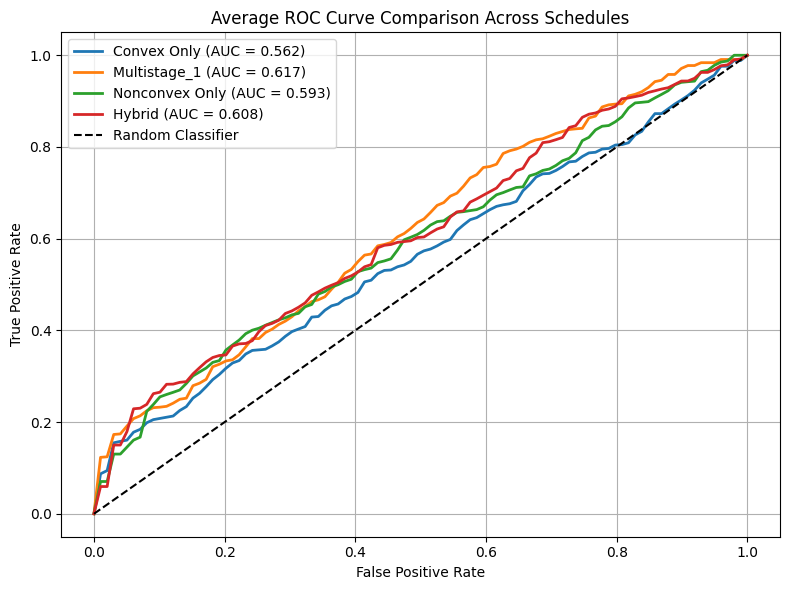

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
shap_feature_importance = {}


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.utils import class_weight




import tensorflow as tf
import tensorflow.keras.backend as K

class NoisyLossWrapper(tf.keras.losses.Loss):
    def __init__(self, base_loss_fn, noise_scale=0.5, name='noisy_loss'):
        super(NoisyLossWrapper, self).__init__(name=name)
        self.base_loss_fn = base_loss_fn
        self.noise_scale = noise_scale

    def call(self, y_true, y_pred):
        base_loss = self.base_loss_fn(y_true, y_pred)
        noise = tf.random.normal(shape=tf.shape(base_loss), mean=0.3, stddev=self.noise_scale) # make noise 0
        return base_loss + noise



def model_builder_convex():
    model = tf.keras.Sequential([
        
        # Handle padded sequences
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Convex-compatible LSTM (tanh + sigmoid only)
        tf.keras.layers.LSTM(
            32,
            activation='tanh',              # smooth, convex-friendly
            recurrent_activation='sigmoid', # safe gating
            return_sequences=False
        ),

        # Convex dense layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='softplus'),
                # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='softplus'),

        # Output (sigmoid for BCE)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model





def model_builder_nonconvex():
    model = tf.keras.Sequential([
        # Handles padded sequences safely
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Non-convex temporal extractor
        tf.keras.layers.LSTM(
            32,
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=False,
           # kernel_initializer='glorot_uniform'
        ),

        # Deep non-convex block
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Output
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model







import tensorflow as tf

class ConvexFocalLoss(tf.keras.losses.Loss):
    """
    Convex-style Focal Loss using convex logistic link (softplus)
    instead of sigmoid. The focal term (1 - p_t)^gamma remains
    dynamic and fully inside the computational graph.
    """
    def __init__(self, gamma=0.5, alpha=0.25,
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
                 name='convex_focal_loss'):
        super().__init__(reduction=reduction, name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred_logits):

        # Softplus-based convex logistic components
        pos_term = tf.nn.softplus(-y_pred_logits)  # convex
        neg_term = tf.nn.softplus(y_pred_logits)   # convex

        # Convex surrogate "probability"
        # p = exp(-softplus(-z)) is convex in logits
        p = tf.exp(-pos_term)

        # Class-dependent p_t
        p_t = y_true * p + (1 - y_true) * (1 - p)

        # ---- Convex surrogate for focal weighting ----
        # Original: (1 - p_t)^gamma      → nonconvex
        # New convex surrogate: exp(-gamma * p_t)
        focal_weight = tf.exp(-self.gamma * p_t)   # convex & monotone decreasing

        # Base convex logistic loss
        base_loss = y_true * pos_term + (1 - y_true) * neg_term

        # Weighted convex loss (convex * convex → convex)
        loss = self.alpha * focal_weight * base_loss

        return tf.reduce_mean(loss)




convex_focal_loss_fn = ConvexFocalLoss(gamma=0.0, alpha=0.1)


#convex_focal_loss = NoisyLossWrapper(convex_focal_loss_fn, noise_scale=0.5)
convex_focal_loss=convex_focal_loss_fn
convex_focal_loss.__name__ = "convex_focal_loss"

nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.25, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#nonconvex_focal_loss = NoisyLossWrapper(nonconvex_focal_loss_fn, noise_scale=0.5)
nonconvex_focal_loss = nonconvex_focal_loss_fn
nonconvex_focal_loss.__name__ = "nonconvex_focal_loss"


hybrid_nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.5, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#hybrid_nonconvex_focal_loss = NoisyLossWrapper(hybrid_nonconvex_focal_loss_fn, noise_scale=0.5)
hybrid_nonconvex_focal_loss = hybrid_nonconvex_focal_loss_fn
hybrid_nonconvex_focal_loss.__name__ = "hybrid_nonconvex_focal_loss"



training_schedule_convex = [
    {"loss_fn": convex_focal_loss, "epochs": 100},
]

training_schedule_multistage_1 = [
    {"loss_fn": convex_focal_loss, "epochs": 10},
     {"loss_fn": nonconvex_focal_loss, "epochs":40},
      {"loss_fn": hybrid_nonconvex_focal_loss, "epochs":50},
]

training_schedule_multistage_2 = [
    {"loss_fn": convex_focal_loss, "epochs":10},
    {"loss_fn": nonconvex_focal_loss, "epochs":90},
]


hybrid_training_schedule_nonconvex = [
    {"loss_fn": hybrid_nonconvex_focal_loss, "epochs": 100},
]

training_schedule_nonconvex = [
    {"loss_fn": nonconvex_focal_loss, "epochs": 100},
]


def cross_validate(schedule, schedule_name, X_data, y_data, k_folds=10):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    metrics_list = []
    roc_data = []

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data)):
        print(f"\n📂 Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
        y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

        result = train_with_schedule_fold(schedule, schedule_name, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold)
        metrics_list.append(result)
        roc_data.append((result["fpr"], result["tpr"]))

    avg_metrics = {
        "loss": np.mean([m["loss"] for m in metrics_list]),
        "accuracy": np.mean([m["accuracy"] for m in metrics_list]),
        "precision": np.mean([m["precision"] for m in metrics_list]),
        "recall": np.mean([m["recall"] for m in metrics_list]),
        "f1": np.mean([m["f1"] for m in metrics_list]),
        "auc": np.mean([m["auc"] for m in metrics_list]),
    }

    print(f"\n📊 Average metrics for schedule '{schedule_name}': {avg_metrics}")
    return avg_metrics, roc_data


def get_model_type_from_loss(loss_fn):
    name = loss_fn.__name__.lower()

    if name.startswith("convex"):
        return "convex"
    elif name.startswith("nonconvex"):
        return "nonconvex"
    elif name.startswith("hybrid"):
        return "nonconvex"   # hybrid is nonconvex
    else:
        raise ValueError(f"Unknown loss type: {loss_fn.__name__}")




def train_with_schedule_fold(schedule, schedule_name, trainX, trainY, testX, testY, fold_index):
    first_loss = schedule[0]["loss_fn"]
    model_type = get_model_type_from_loss(first_loss)

    if model_type == "convex":
        model = model_builder_convex()
        #print(f"[FOLD {fold_index}] Using CONVEX model for loss: {first_loss.__name__}")

    else:
        model = model_builder_nonconvex()
        #print(f"[FOLD {fold_index}] Using NON-CONVEX model for loss: {first_loss.__name__}")

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    current_epoch = 0

    for i, stage in enumerate(schedule):
        loss_fn = stage["loss_fn"]
        epochs = stage["epochs"]
        print(f"\n➡️ Stage {i + 1} | Epochs: {epochs} | Loss: {loss_fn.__name__}")

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        model.fit(
            trainX, trainY,
            initial_epoch=current_epoch,
            epochs=current_epoch + epochs,
            batch_size=1,
            validation_data=(testX, testY),
            verbose=0
        )
        current_epoch += epochs

    eval_results = model.evaluate(testX, testY, verbose=0)
    y_pred_prob = model.predict(testX, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(testY, y_pred)
    auc_score = roc_auc_score(testY, y_pred_prob)
    fpr, tpr, _ = roc_curve(testY, y_pred_prob)

    # SHAP values for fold 1 only
    if fold_index == 0:
        print(f"🔍 Calculating SHAP values for fold 1 of '{schedule_name}'")
        background = trainX[:100].astype(np.float32)
        test_sample = testX[:100].astype(np.float32)

        # Recompile without metrics for SHAP
        model.compile(optimizer=optimizer, loss=loss_fn)

        explainer = shap.GradientExplainer(model, background)
        shap_values = explainer.shap_values(test_sample)[0]

        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = getattr(testX, "columns", [f"Feature {i}" for i in range(testX.shape[1])])
        shap_feature_importance[schedule_name] = dict(zip(feature_names, mean_abs_shap))

    return {
        "loss": eval_results[0],
        "accuracy": eval_results[1],
        "precision": eval_results[2],
        "recall": eval_results[3],
        "auc": auc_score,
        "f1": f1,
        "fpr": fpr,
        "tpr": tpr
    }

def average_roc_curves(roc_data, num_points=100):
    mean_fpr = np.linspace(0, 1, num_points)
    tprs = []

    for fpr, tpr in roc_data:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc

# 🧪 Run experiments and collect metrics
results_cv = {}
roc_data_schedules = {}


results_cv["Convex Only"], roc_data_schedules["Convex Only"] = cross_validate(training_schedule_convex, "Convex Only", X_resampled, y_resampled)
results_cv["Multistage_1"], roc_data_schedules["Multistage_1"] = cross_validate(training_schedule_multistage_1, "Multistage_1", X_resampled, y_resampled)
results_cv["Nonconvex Only"], roc_data_schedules["Nonconvex Only"] = cross_validate(training_schedule_nonconvex, "Nonconvex Only", X_resampled, y_resampled)
results_cv["Hybrid"], roc_data_schedules["Hybrid"] = cross_validate(hybrid_training_schedule_nonconvex, "Hybrid", X_resampled, y_resampled)
#results_cv["Multistage_2"], roc_data_schedules["Multistage_2"] = cross_validate(training_schedule_multistage_2, "Multistage_2", X_resampled, y_resampled)


# 📤 Export metrics to CSV
results_df = pd.DataFrame.from_dict(results_cv, orient='index')
results_df.to_csv("cross_validation_results_2.csv", index_label="Schedule")
print("✅ Metrics exported to 'cross_validation_results_2.csv'")

# 📊 Plot average ROC curves
plt.figure(figsize=(8, 6))
for name, data in roc_data_schedules.items():
    fpr, tpr, auc_val = average_roc_curves(data)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("Average ROC Curve Comparison Across Schedules")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 📊 SHAP Comparison Bar Plot
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)
#shap_df["mean"] = shap_df.mean(axis=1)
shap_df
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")

#shap_df = shap_df.sort_values("mean", ascending=True)
#shap_df.drop("mean", axis=1, inplace=True)


In [6]:
import numpy as np
import pandas as pd

# Suppose shap_feature_importance is a dict of lists or arrays
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)

# Flatten array entries
shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)

# Now compute row-wise mean
shap_df["mean"] = shap_df.mean(axis=1, numeric_only=True)

# Save
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")
shap_df.head()



/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_41178/4213904531.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)


,Convex Only,Multistage_1,Nonconvex Only,Hybrid,mean
Feature 0,1.551484e-08,9.037708e-07,3.801324e-09,1.445644e-06,5.921826e-07
Feature 1,2.771408e-04,1.774584e-03,1.136564e-06,1.231857e-02,3.592857e-03
Feature 2,4.764691e-10,2.092145e-08,3.466528e-10,2.026611e-07,5.610143e-08
Feature 3,1.415412e-06,1.955903e-05,5.555564e-08,2.024000e-04,5.585750e-05
Feature 4,1.949135e-03,6.109911e-04,7.230977e-07,7.674537e-05,6.593987e-04


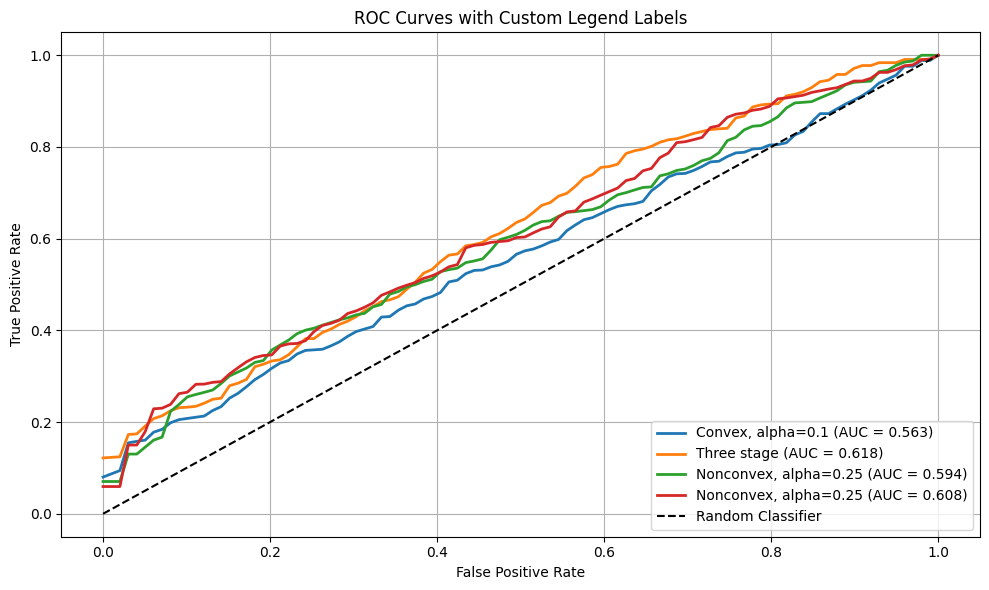

✅ Saved:
 - roc_custom_legend.png (ROC plot)
 - roc_summary_results.csv (AUC summary)
 - roc_curve_points.csv (All FPR–TPR points)


,Schedule,Label,AUC
0,Convex Only,"Convex, alpha=0.1",0.562583
1,Multistage_1,Three stage,0.617763
2,Nonconvex Only,"Nonconvex, alpha=0.25",0.593773
3,Hybrid,"Nonconvex, alpha=0.25",0.608220


,Schedule,FPR,TPR
0,Convex Only,0.000000,0.080091
1,Convex Only,0.010101,0.087173
2,Convex Only,0.020202,0.094256
3,Convex Only,0.030303,0.154845
4,Convex Only,0.040404,0.157962


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# === Function to compute average ROC curve ===
def average_roc_curves(roc_data_list):
    """
    roc_data_list: list of tuples [(fpr, tpr)] or [(fpr, tpr, auc_val)]
    Returns averaged fpr, tpr, and mean AUC
    """
    fpr_grid = np.linspace(0, 1, 100)
    tpr_interp = []
    auc_vals = []

    for entry in roc_data_list:
        # Handle 2-tuple or 3-tuple gracefully
        if len(entry) == 2:
            fpr, tpr = entry
        elif len(entry) == 3:
            fpr, tpr, _ = entry
        else:
            raise ValueError(f"Unexpected ROC entry shape: {entry}")
        tpr_interp.append(np.interp(fpr_grid, fpr, tpr))
        auc_vals.append(auc(fpr, tpr))

    mean_tpr = np.mean(tpr_interp, axis=0)
    mean_auc = np.mean(auc_vals)
    return fpr_grid, mean_tpr, mean_auc


# === Plot ROC curves ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
    "Nonconvex Only": "Nonconvex, alpha=0.25",
    "Hybrid": "Nonconvex, alpha=0.25",
   # "Multistage_2": "Two stage",
}

results = []
roc_points = []  # store all averaged ROC points

plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in roc_data_schedules:
        fpr, tpr, auc_val = average_roc_curves(roc_data_schedules[schedule])
        label = f"{legend_labels.get(schedule, schedule)} (AUC = {auc_val:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

        # Summary results
        results.append({
            "Schedule": schedule,
            "Label": legend_labels.get(schedule, schedule),
            "AUC": auc_val
        })

        # Store every (fpr, tpr) point
        for i in range(len(fpr)):
            roc_points.append({
                "Schedule": schedule,
                "FPR": fpr[i],
                "TPR": tpr[i]
            })
    else:
        print(f"⚠️ Warning: No ROC data for '{schedule}'")

# === Plot styling ===
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Custom Legend Labels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# === Save figure and data ===
plt.savefig("roc_custom_legend.png", dpi=300)
plt.show()

# Save AUC summary
roc_summary = pd.DataFrame(results)
roc_summary.to_csv("roc_summary_results.csv", index=False)

# Save all ROC points
roc_points_df = pd.DataFrame(roc_points)
roc_points_df.to_csv("roc_curve_points.csv", index=False)

print("✅ Saved:")
print(" - roc_custom_legend.png (ROC plot)")
print(" - roc_summary_results.csv (AUC summary)")
print(" - roc_curve_points.csv (All FPR–TPR points)")
display(roc_summary.head())
display(roc_points_df.head())


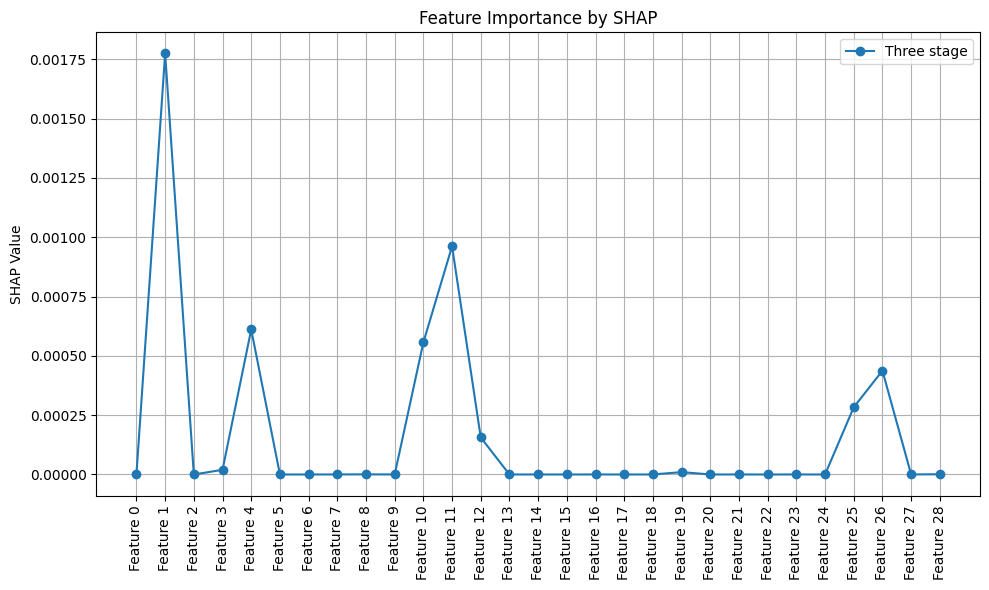

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === Load and preprocess the SHAP file ===
shap_df = pd.read_csv("cross_validation_shap_2.csv")
shap_df.columns = shap_df.columns.str.strip()

# Convert SHAP value strings to floats
for col in shap_df.columns[1:]:
    shap_df[col] = shap_df[col].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

# === Step 1: Define original and custom legend names ===
selected_schedules = ["Multistage_1"]
legend_labels = {
    #"Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
   # "Nonconvex Only": "Nonconvex, alpha=0.25",
   # "Hybrid": "Nonconvex, alpha=0.5",
    #"Multistage_2": "Two stage",
}

# === Step 2: Plot each schedule with a custom label ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in shap_df.columns:
        plt.plot(shap_df["Schedule"], shap_df[schedule], marker='o', label=legend_labels.get(schedule, schedule))
    else:
        print(f"Warning: Schedule '{schedule}' not found.")

plt.xticks(rotation=90)
plt.ylabel("SHAP Value")
plt.title("Feature Importance by SHAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("shap_plot_custom_legend.png")
plt.show()
